In [15]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!


In [98]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# data_dir_full = db.query('sess_name=="e15_13f1_220117"')['data_dir_full'][0]

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


In [4]:
import behavior_analysis as ba
reload(ba)

<module 'behavior_analysis' from '/mnt/home/szheng/projects/place_variability/code/behavior_analysis.py'>

In [173]:
reload(dpp)
beh_df_fix=dpp.get_multi_maze_behavior_df(behavior,d_cutoff=1.,min_cutoff=0.05,beta=0.1)

<AxesSubplot:xlabel='Time (s)'>

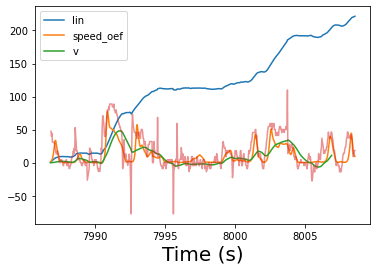

In [174]:
tr = 5
ax=beh_df_fix.query('task_index==0&(trial==@tr)')[['lin','speed_oef','v']].plot()
(beh_df_fix.query('task_index==0&(trial==@tr)')['lin'].diff()*50).plot(ax=ax,alpha=0.5)

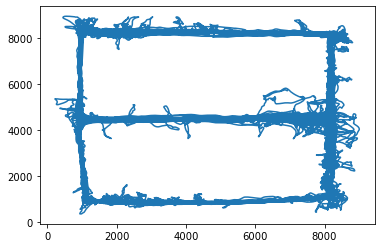

In [69]:
%matplotlib inline
beh_df_sub=beh_df.query('task_index==0')
plt.plot(beh_df_sub['x']*100,beh_df_sub['y']*100)

<AxesSubplot:xlabel='Time (s)'>

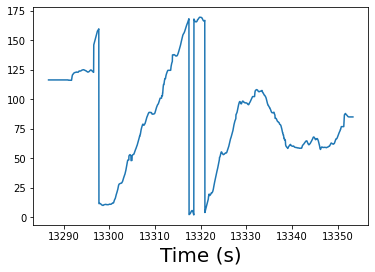

In [34]:
beh_df_sub['lin'].iloc[:2000].plot()

In [5]:
spk_beh_df = spk_beh_df.reset_index().rename({'Time (s)':'time'},axis=1)

In [135]:
reload(oef)

<module 'one_euro_filter' from '/mnt/home/szheng/projects/util_code/one_euro_filter.py'>

In [136]:
reload(dpp)
beh_df=dpp.get_multi_maze_behavior_df(behavior)

In [137]:
beh_df=beh_df.reset_index().rename({'Time (s)':'time'},axis=1)

# visualize stop and low speed chunks

In [6]:
bins = (0,1,5,np.inf)

In [9]:
beh_df_sub = beh_df.query('task_index==0')

In [10]:
run_state=pd.cut(beh_df_sub['speed_oef'],bins,labels=False,retbins=False,right=False)
beh_df_sub['run_state']=run_state

/tmp/ipykernel_801384/727862150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh_df_sub['run_state']=run_state


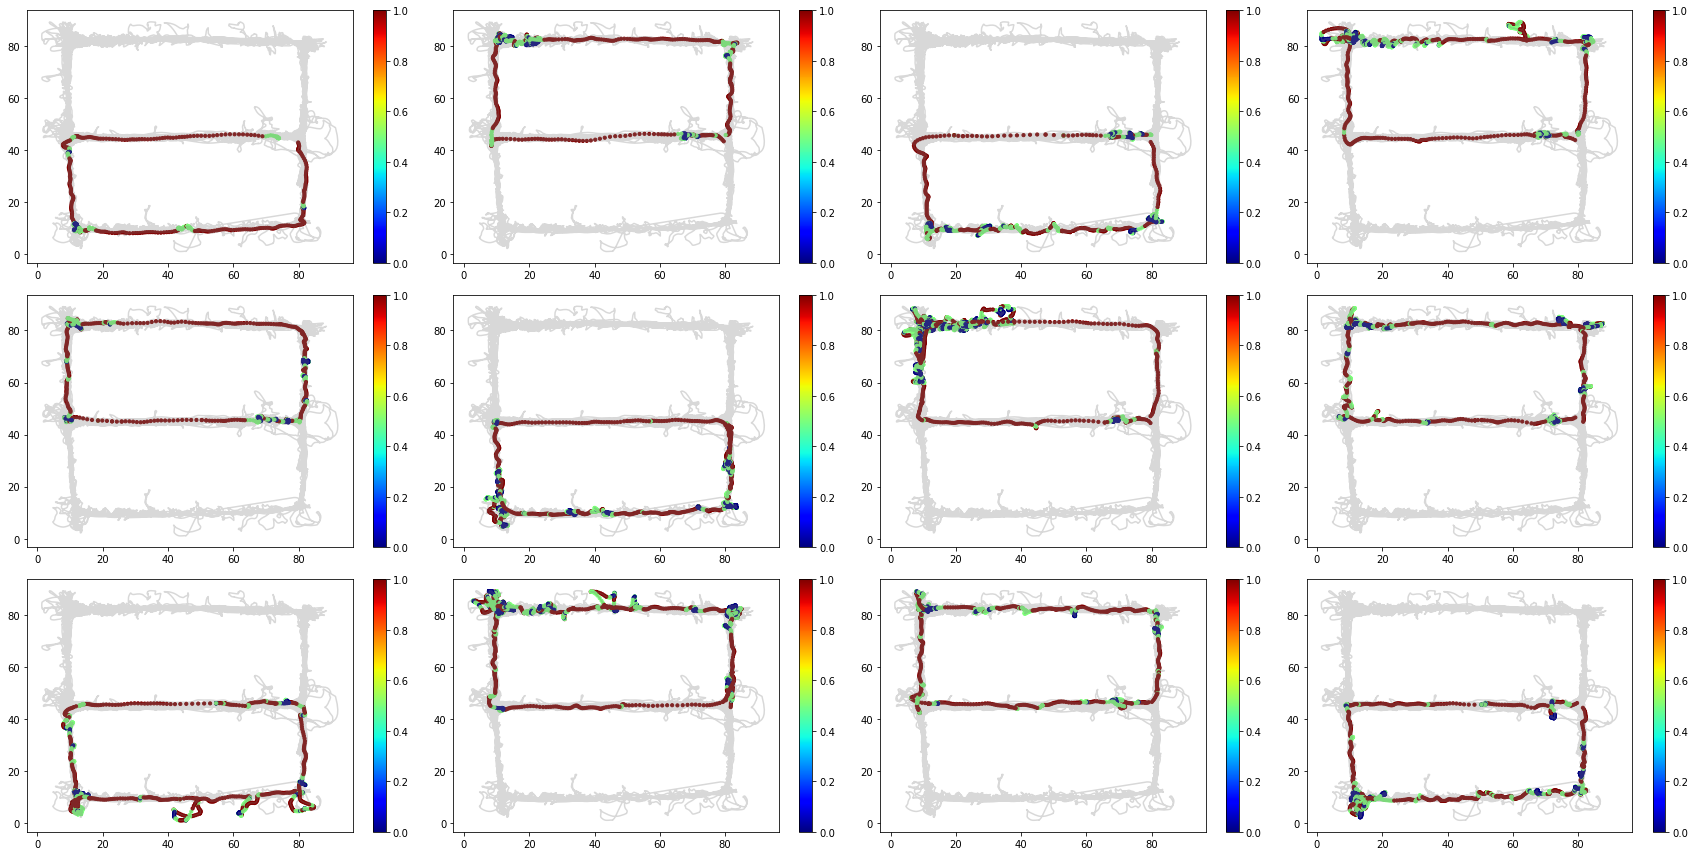

In [11]:
trial_l = list(range(12))#list(range(70-12,70))
nplots=len(trial_l)
fig,axs = ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l):
    ax = axs.ravel()[ii]
    one_chunk = beh_df_sub.query('trial==@tr')
    colors = one_chunk['run_state']
    fig,ax=ba.plot_one_headscan(beh_df_sub,one_chunk,colors=colors,fig=fig,ax=ax)
plt.tight_layout()


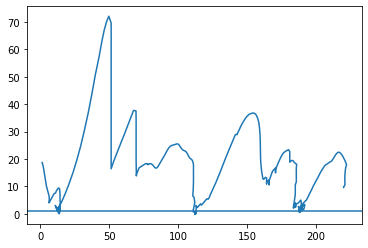

In [38]:
%matplotlib inline
plt.plot(one_chunk['lin'],speed_l)
plt.axhline(1)

<IPython.core.display.Javascript object>


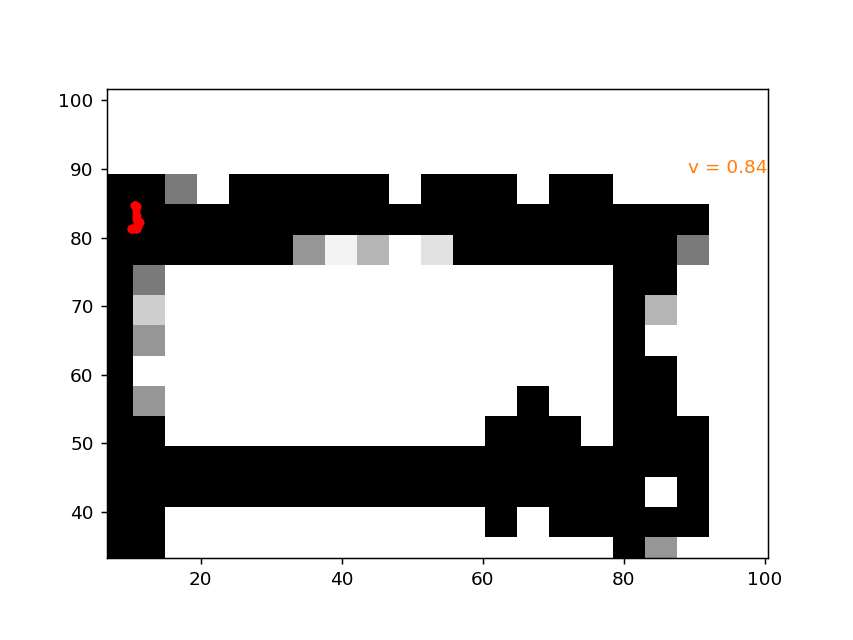

In [14]:
%matplotlib notebook
# %%time


import animate_helper as ah
reload(ah)
tr=1
one_chunk = beh_df_sub.query('trial==@tr')
data = one_chunk[['x','y']].values.T
x_all = beh_df_sub['x'].values
y_all = beh_df_sub['y'].values
speed_l = one_chunk['speed_oef'].values
save_dir = os.path.join(data_dir_full,'py_figures','behavior')
DO_SAVE=False

save_fn = f'behavior_trial{tr}.mp4'

fig,ax,ani=ah.animate_movement_in_maze(data,x_all,y_all,hist2d_kws={},ax_kws={},fig=None,ax=None,
                                    animate_kws={'interval':30},dosave=DO_SAVE,
                                    do_plot_background_maze=True,
                                    n_tail=100,trial_l=None,speed_l=speed_l,
                                    save_dir=save_dir,save_fn=save_fn
                                )

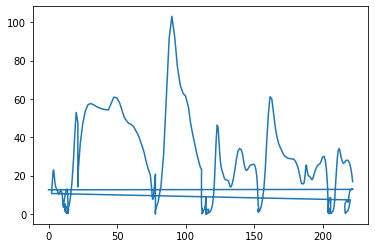

In [159]:
%matplotlib inline
plt.plot(one_chunk['lin'],one_chunk['speed_oef'])

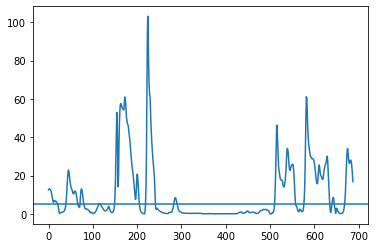

In [165]:
ax=one_chunk.reset_index()['speed_oef'].plot()
ax.axhline(5)

In [189]:
is_low_speed=(beh_df['run_state']==1).astype(int)
is_low_speed_diff = np.diff(is_low_speed)
st = np.nonzero(is_low_speed_diff==1)[0]
ed = np.nonzero(is_low_speed_diff==-1)[0]

In [190]:
# correct for edges
ntimes = beh_df.shape[0]
if len(st) < len(ed):
    st = np.insert(st,0,0)
elif len(st) > len(ed):
    ed = np.append(ed,ntimes-1)

In [191]:
seg_l = []
for s,e in zip(st,ed):
    seg_l.append([s,e])
seg_l = np.array(seg_l)

In [192]:
seg_l

array([[    9,    14],
       [   31,    35],
       [   39,    46],
       ...,
       [64690, 64693],
       [64705, 64729],
       [64791, 64795]])

In [155]:
import matplotlib
plt.rcParams['animation.ffmpeg_path'] = '/mnt/sw/nix/store/d31vr73pr36ir62cwm9sqsjdr6cp0dxv-ffmpeg-4.4.1-bin/bin/ffmpeg'
FFwriter = matplotlib.animation.FFMpegWriter()
ani.save('test.mp4', writer = FFwriter)


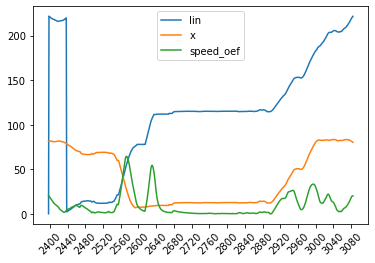

In [75]:
%matplotlib inline
from matplotlib.ticker import MaxNLocator
ax=one_chunk[['lin','x','speed_oef']].plot()
ax.xaxis.set_major_locator(MaxNLocator(20))
ax.tick_params(axis='x', rotation=45)


In [106]:
import one_euro_filter as oef
reload(oef)

<module 'one_euro_filter' from '/mnt/home/szheng/projects/util_code/one_euro_filter.py'>

In [133]:
_,v_oef=oef.get_speed_one_euro_filter(one_chunk[['x','y']].values,one_chunk.time.values,beta=0.2,min_cutoff=0.05,d_cutoff=1.)
sp_oef = np.sqrt(v_oef[:,0]**2+v_oef[:,1]**2)



<IPython.core.display.Javascript object>


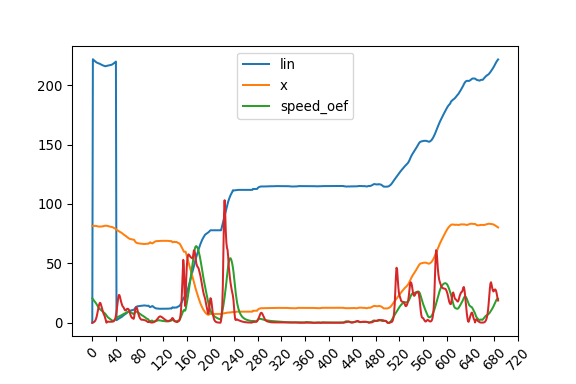

In [134]:
ax=one_chunk.reset_index()[['lin','x','speed_oef']].plot()
ax.xaxis.set_major_locator(MaxNLocator(20))
ax.tick_params(axis='x', rotation=45)
ax.plot(sp_oef)

<IPython.core.display.Javascript object>


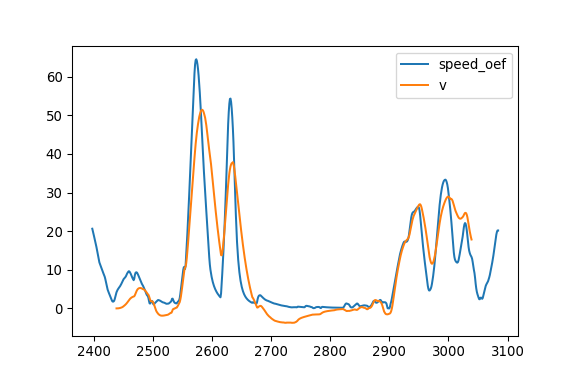

<AxesSubplot:>

In [49]:
one_chunk[['speed_oef','v']].plot()

# check firing rate vs state

In [7]:
# different state firing rate:
bins = (0,1,5,np.inf)
run_state=pd.cut(spk_beh_df['speed_oef'],bins,labels=False,retbins=False,right=False)
spk_beh_df['run_state']=run_state


In [8]:
state_avg = spk_beh_df.groupby('run_state').mean()
dt = 0.033
state_avg_fr = state_avg[cell_cols_d['all']].T / dt

In [10]:
states_l = state_avg_fr.columns
state_avg_fr_tuning = {}
for state in states_l:
    nonstate = states_l[states_l!=state]
    state_avg_fr_tuning['tuning_'+str(state)] = (state_avg_fr[state] - state_avg_fr[nonstate].sum(axis=1)) / state_avg_fr.sum(axis=1)
state_avg_fr_tuning = pd.DataFrame(state_avg_fr_tuning)

state_avg_fr_and_tuning = pd.concat([state_avg_fr,state_avg_fr_tuning],axis=1)

state_avg_fr_and_tuning['mean_fr'] = spk_beh_df[cell_cols_d['all']].mean()/dt

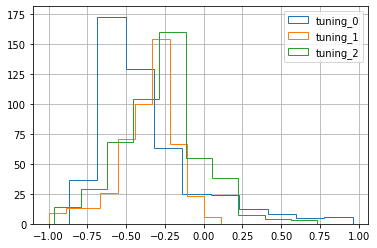

In [260]:
state_avg_fr_tuning['tuning_0'].hist(histtype='step')
state_avg_fr_tuning['tuning_1'].hist(histtype='step')
state_avg_fr_tuning['tuning_2'].hist(histtype='step')
plt.legend(state_avg_fr_tuning.columns)

In [263]:
state_avg_fr_and_tuning.pcorr()

,0,1,2,tuning_0,tuning_1,tuning_2,mean_fr
0,1.000000,0.565706,-0.269305,0.316995,-0.257529,0.106571,-0.749964
1,0.565706,1.000000,0.945118,-0.206149,0.535551,-0.512500,0.966485
2,-0.269305,0.945118,1.000000,0.105547,-0.518464,0.556514,-0.838207
tuning_0,0.316995,-0.206149,0.105547,1.000000,0.557546,-0.029317,0.245019
tuning_1,-0.257529,0.535551,-0.518464,0.557546,1.000000,0.846135,-0.497124
tuning_2,0.106571,-0.512500,0.556514,-0.029317,0.846135,1.000000,0.441275
mean_fr,-0.749964,0.966485,-0.838207,0.245019,-0.497124,0.441275,1.000000



KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1554ccf80ca0> (for post_execute):


KeyboardInterrupt: 

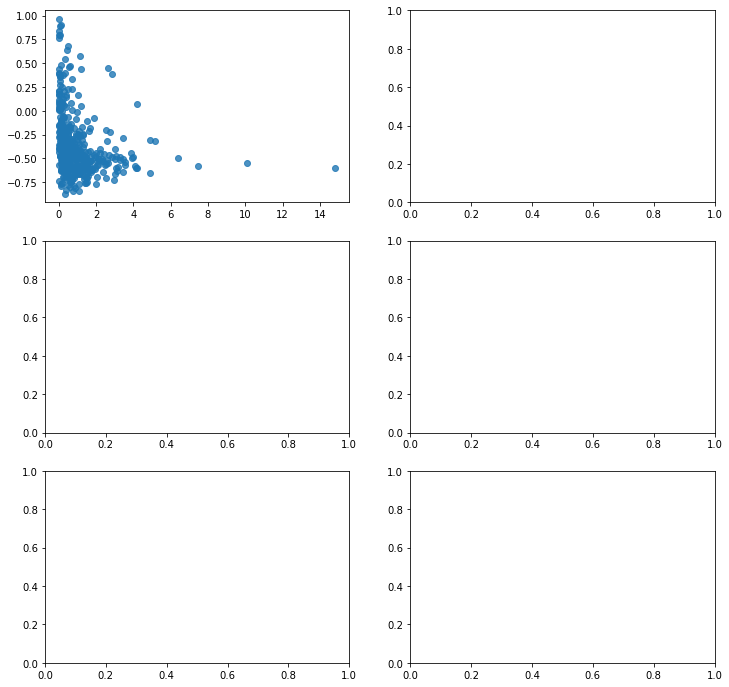

In [264]:
fig,axs = plt.subplots(3,2,figsize=(2*6,3*4))
for ii,i in enumerate(states_l):
    sns.regplot(data=state_avg_fr_and_tuning.loc[cell_cols_d['pyr']],x='mean_fr',y=f'tuning_{i}',ax=axs[ii,0],robust=True)
    axs[ii,0].set_title('pyr')
    sns.regplot(data=state_avg_fr_and_tuning.loc[cell_cols_d['int']],x='mean_fr',y=f'tuning_{i}',ax=axs[ii,1],robust=True)
    axs[ii,1].set_title('int')
plt.tight_layout()

# does it make sense to seperate fast and slow running?

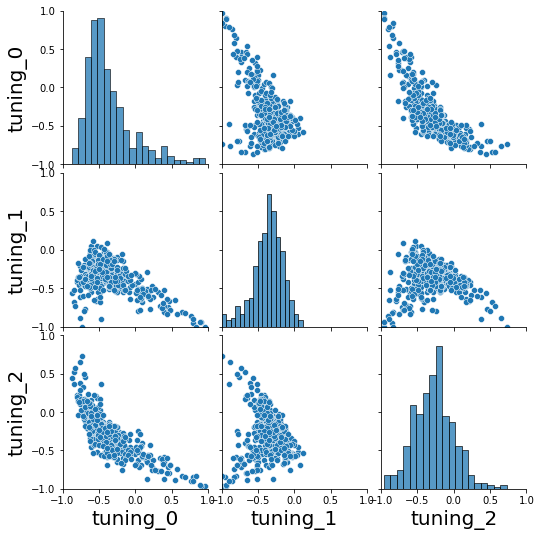

In [265]:
g=sns.pairplot(data=state_avg_fr_tuning.loc[cell_cols_d['pyr']])
for ax in g.axes.flat:
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])

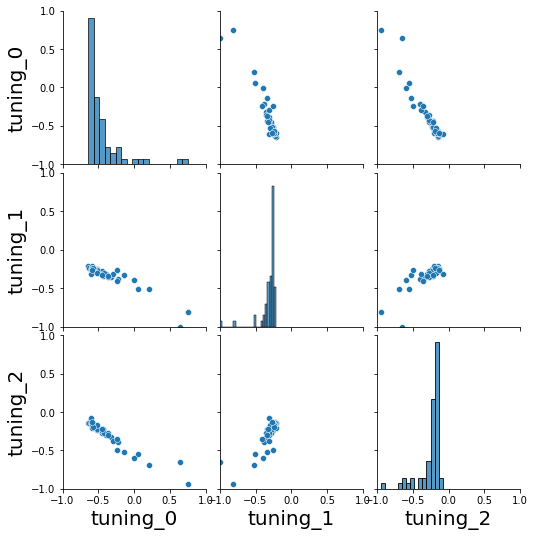

In [266]:
g=sns.pairplot(data=state_avg_fr_tuning.loc[cell_cols_d['int']])
for ax in g.axes.flat:
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])

# rate map different state

In [11]:
ratemap_by_state = spk_beh_df.groupby(['visitedArm','run_state','lin_binned']).mean()[cell_cols_d['pyr']]/dt

In [293]:
pd.set_option('display.max_rows', 500)

In [12]:
# see some tuned to pause:
tuning_i = 1
state_avg_fr_and_tuning_sorted=state_avg_fr_and_tuning.loc[cell_cols_d['pyr']].sort_values([f'tuning_{tuning_i}','mean_fr'],ascending=False)
to_plot = state_avg_fr_and_tuning_sorted.query('mean_fr>=0.8').iloc[:12]
to_plot



,0,1,2,tuning_0,tuning_1,tuning_2,mean_fr
274,1.188188,2.993116,1.060747,-0.546671,0.141964,-0.595293,1.517122
190,1.407399,3.052071,1.192167,-0.501950,0.080066,-0.578116,1.672448
208,1.063227,2.739154,1.283356,-0.581879,0.077191,-0.495312,1.487090
232,0.859901,1.975003,1.047337,-0.557008,0.017455,-0.460447,1.156260
385,0.630100,1.369577,0.724151,-0.537342,0.005627,-0.468284,0.816046
312,1.608607,3.569064,1.944479,-0.548280,0.002243,-0.453963,2.131855
121,0.967918,1.634876,0.669169,-0.408356,-0.000676,-0.590968,1.001404
278,0.558088,1.396787,0.894460,-0.608268,-0.019570,-0.372162,0.849363
305,0.694698,1.306087,0.695989,-0.484793,-0.031371,-0.483836,0.821677
187,0.755061,1.673424,1.050019,-0.565870,-0.037848,-0.396281,1.048330


In [46]:
def pad_and_pearsonr(x1,x2):
    return pd.concat([x1,x2],axis=1).corr().iloc[0,1]

In [48]:
tt = 0
state_1_2_corr = ratemap_by_state.loc[tt].apply(lambda x:pad_and_pearsonr(x.loc[1],x.loc[2]),axis=0)

In [49]:
state_avg_fr_and_tuning['corr_12'] = state_1_2_corr

In [13]:
nplots = to_plot.shape[0]

In [53]:
ascending = True
state_avg_fr_and_tuning_sorted=state_avg_fr_and_tuning.loc[cell_cols_d['pyr']].sort_values(['corr_12','mean_fr'],ascending=ascending)
to_plot = state_avg_fr_and_tuning_sorted.query('mean_fr>=0.8').iloc[:12]
to_plot

,0,1,2,tuning_0,tuning_1,tuning_2,mean_fr,corr_12
285,0.562324,0.882062,1.713824,-0.643897,-0.441416,0.085313,1.031437,-0.097676
235,1.248551,0.886597,0.606141,-0.089078,-0.353153,-0.557769,0.948847,-0.056706
320,0.705288,0.975030,0.850207,-0.442576,-0.229385,-0.328039,0.811822,-0.045205
58,0.770946,1.070266,2.232798,-0.621530,-0.474589,0.096118,1.344434,0.002476
236,4.987848,1.090673,1.223010,0.366247,-0.701248,-0.664999,2.863903,0.015128
459,0.684108,0.657578,1.251172,-0.472313,-0.492777,-0.034909,0.877050,0.025340
283,0.516788,0.630368,1.532786,-0.614329,-0.529566,0.143895,0.895820,0.036758
288,0.575032,1.383182,2.814801,-0.759049,-0.420416,0.179464,1.526038,0.042465
273,2.176227,0.562343,0.265522,0.448842,-0.625615,-0.823226,1.173623,0.062256
247,1.183952,1.104278,1.074157,-0.295767,-0.343158,-0.361075,1.129043,0.079928


<IPython.core.display.Javascript object>


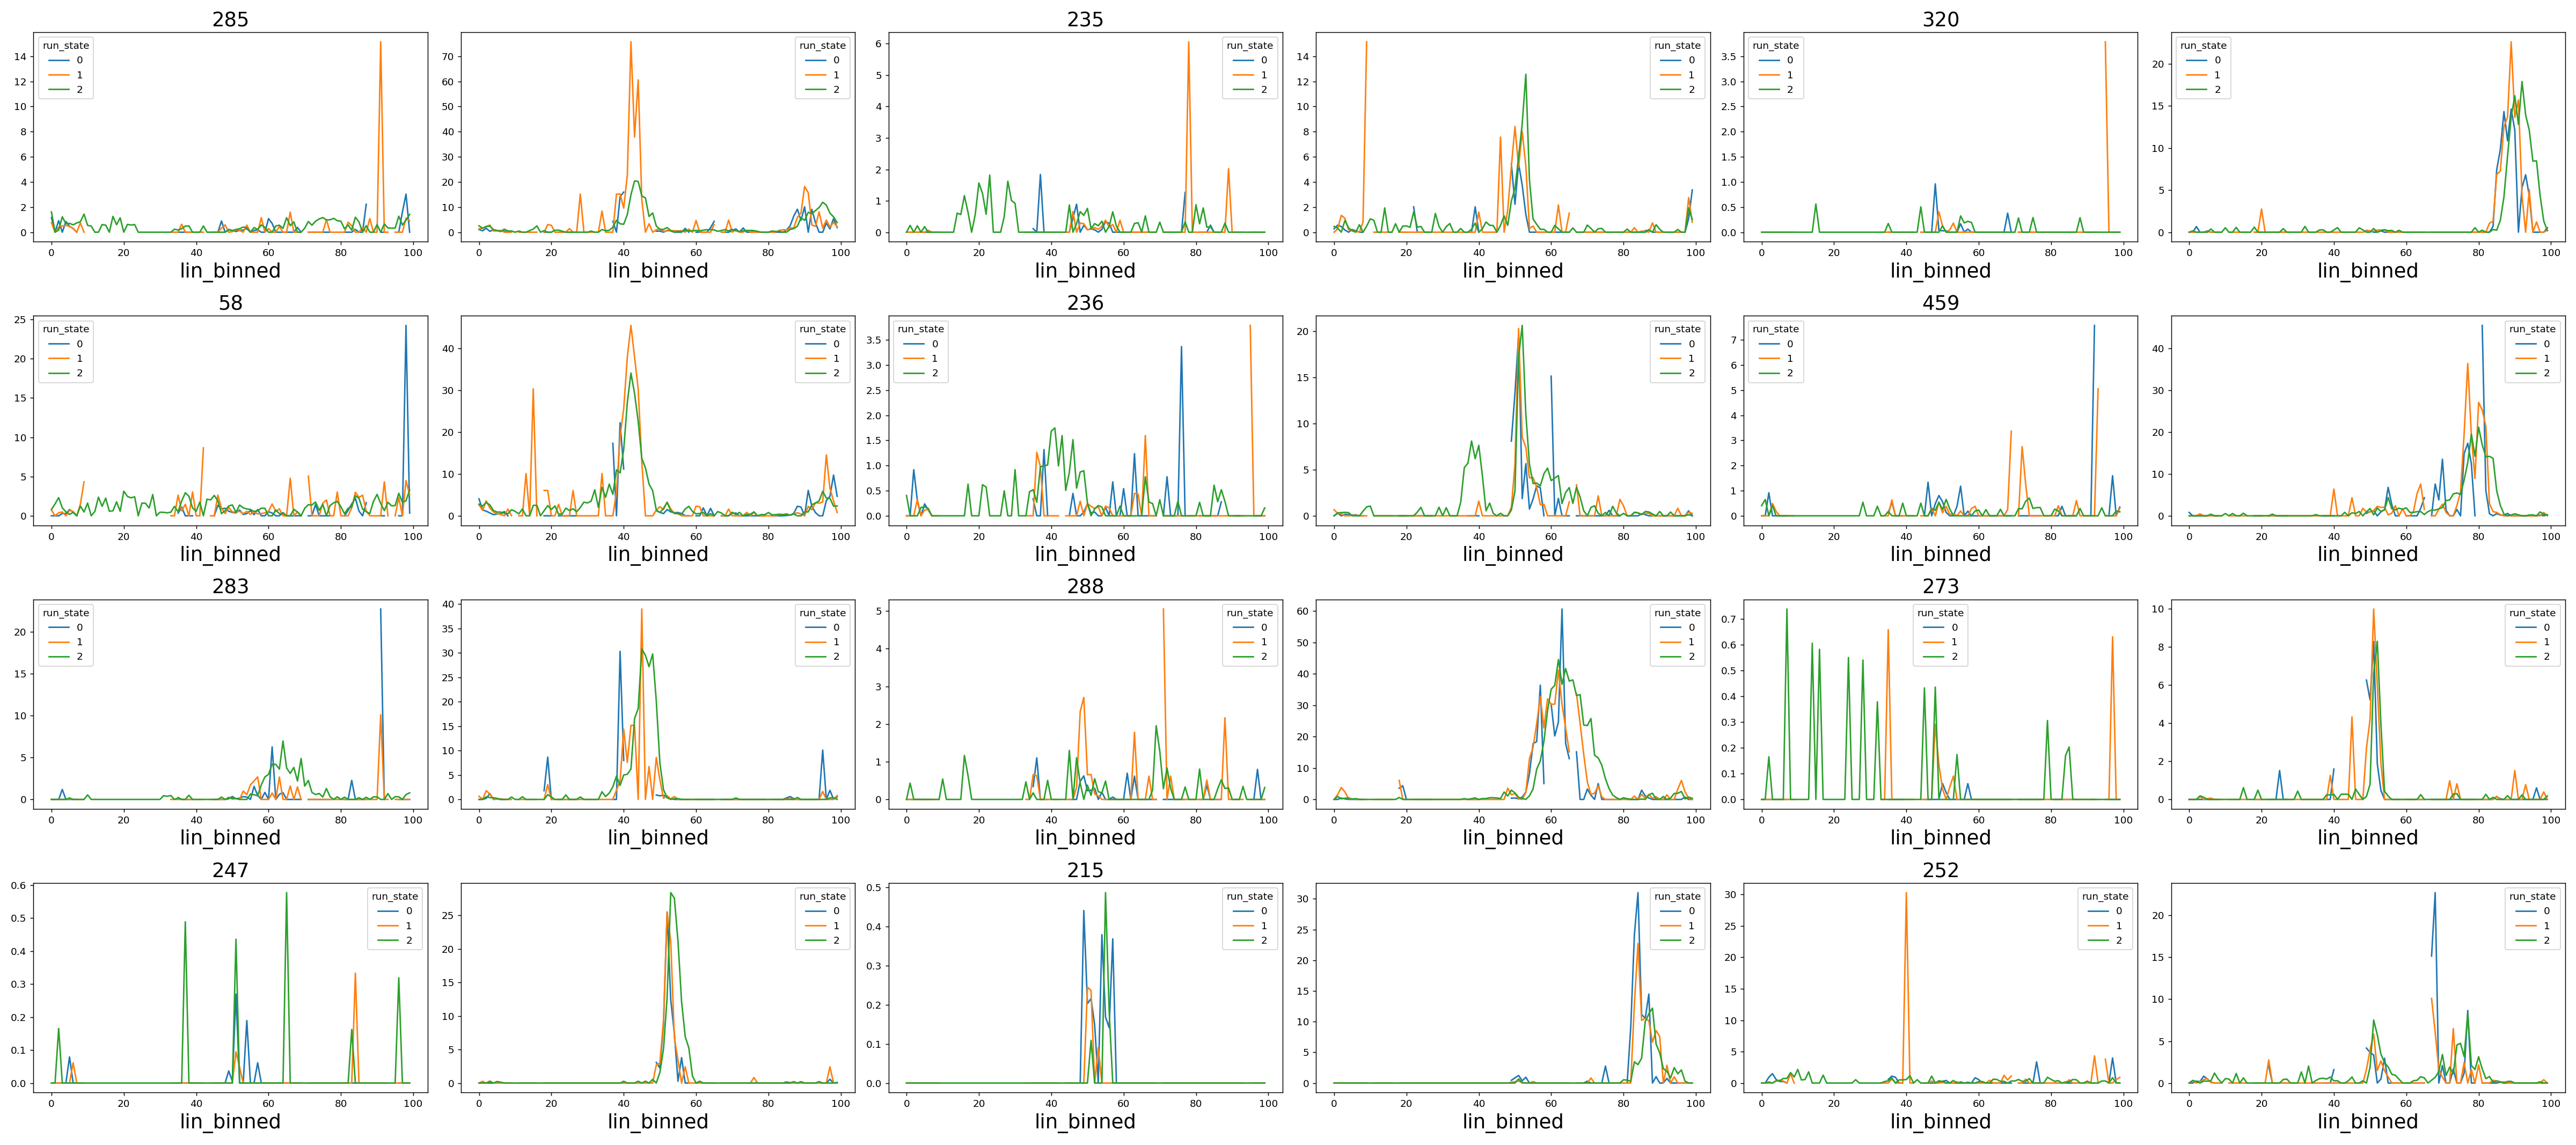

In [54]:
%matplotlib notebook
fig,axs=ph.subplots_wrapper(nplots*2)
for ii in range(nplots):
    to_plot_ind = to_plot.index[ii]
    ax = axs.ravel()[ii*2]
    ratemap_by_state.loc[0,to_plot_ind].unstack().T.plot(ax=ax)
    ax.set_title(to_plot_ind)
    ax = axs.ravel()[ii*2+1]
    ratemap_by_state.loc[1,to_plot_ind].unstack().T.plot(ax=ax)
plt.tight_layout()

In [64]:
class OneEuroFilter:
    def __init__(self, min_cutoff=0.2, beta=0.01, d_cutoff=1.0):
        self.min_cutoff = min_cutoff
        self.beta = beta
        self.d_cutoff = d_cutoff
        self.x_prev = None
        self.dx_prev = None
        self.timestamp_prev = None

    def alpha(self, cutoff,dt):
        r = 2 * np.pi * cutoff*dt
        return r / (r + 1.0)

    def apply(self, x, timestamp):
        if self.x_prev is None:
            result = x
        else:
            dt = timestamp - self.timestamp_prev
            alpha_x = self.alpha(self.min_cutoff + self.beta * np.abs(self.dx_prev),dt)
            result = alpha_x * x + (1 - alpha_x) * self.x_prev

        if self.dx_prev is None:
            dx = 0
        else:
            alpha_dx = self.alpha(self.d_cutoff,dt)
            dx = (result - self.x_prev) / dt
            dx = alpha_dx * dx + (1 - alpha_dx) * self.dx_prev

        self.x_prev = result
        self.dx_prev = dx
        self.timestamp_prev = timestamp

        return result

In [65]:
xy_smth = []
min_cutoff = 0.05
beta=0.02
oef_x = OneEuroFilter(min_cutoff=min_cutoff,beta=beta)
oef_y = OneEuroFilter(min_cutoff=min_cutoff,beta=beta)
ntimes=2000#beh_df.shape[0]#2000#
xy_raw=[]
for i in range(ntimes):
    x,y,t = beh_df['x'].iloc[i],beh_df['y'].iloc[i],beh_df.index[i]
    x_smth=oef_x.apply(x,t)
    y_smth=oef_y.apply(y,t)
    xy_smth.append([x_smth,y_smth])
    xy_raw.append([x,y])
xy_smth = np.array(xy_smth)    
xy_raw = np.array(xy_raw)

In [307]:
import one_euro_filter as oef
reload(oef)
xy = beh_df[['x','y']].values
timestamps = beh_df.index
beta = 0.01
min_cutoff = 0.1
xy_smth, v = oef.get_speed_one_euro_filter(xy,timestamps,beta=beta,min_cutoff=min_cutoff)



In [67]:

beh_df['vx_oef'] = np.gradient(xy_smth[:,0]) / dt
beh_df['vy_oef'] = np.gradient(xy_smth[:,1]) / dt

beh_df['vx_raw'] = np.gradient(beh_df['x']) / dt
beh_df['vy_raw'] = np.gradient(beh_df['y']) / dt

ValueError: Length of values (2000) does not match length of index (64796)

In [267]:
sub_beh_df = copy.copy(beh_df).reset_index()

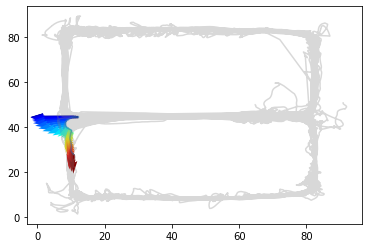

In [255]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(sub_beh_df['x'],sub_beh_df['y'],color='grey',alpha=0.3)
# one_chunk =sub_beh_df.query('trial==0').iloc[::5]
one_chunk =sub_beh_df.loc[458:490]
ax.plot(one_chunk['x'],one_chunk['y'],alpha=0.5)
colors = np.arange(one_chunk.shape[0])
cmap = plt.get_cmap('jet')
norm = plt.Normalize(min(colors), max(colors))
ax.quiver(one_chunk['x'],one_chunk['y'],one_chunk['vx_oef'],one_chunk['vy_oef'],colors,angles='xy',scale_units='xy',scale=2,
          cmap=cmap,norm=norm
         )

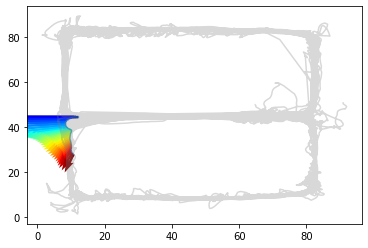

In [256]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(sub_beh_df['x'],sub_beh_df['y'],color='grey',alpha=0.3)
# one_chunk =sub_beh_df.query('trial==0').iloc[::5]
one_chunk =sub_beh_df.loc[458:490]
ax.plot(one_chunk['x'],one_chunk['y'],alpha=0.5)
colors = np.arange(one_chunk.shape[0])
cmap = plt.get_cmap('jet')
norm = plt.Normalize(min(colors), max(colors))
ax.quiver(one_chunk['x'],one_chunk['y'],one_chunk['vx_kalman'],one_chunk['vy_kalman'],colors,angles='xy',scale_units='xy',scale=2,
          cmap=cmap,norm=norm
         )

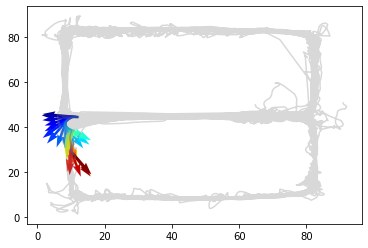

In [268]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(sub_beh_df['x'],sub_beh_df['y'],color='grey',alpha=0.3)
# one_chunk =sub_beh_df.query('trial==0').iloc[::5]
one_chunk =sub_beh_df.loc[458:490]
ax.plot(one_chunk['x'],one_chunk['y'],alpha=0.5)
colors = np.arange(one_chunk.shape[0])
cmap = plt.get_cmap('jet')
norm = plt.Normalize(min(colors), max(colors))
ax.quiver(one_chunk['x'],one_chunk['y'],one_chunk['vx_raw'],one_chunk['vy_raw'],colors,angles='xy',scale_units='xy',scale=2,
          cmap=cmap,norm=norm
         )

In [309]:
vx_smth=np.gradient(xy_smth[:,0])/dt
vx_raw=np.gradient(xy_raw[:,0])/dt

In [238]:
xy_smth_kalman=dpp.get_speed_kalman(beh_df[['x','y']].values[:ntimes])

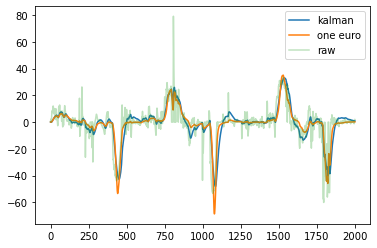

In [310]:
plt.plot(xy_smth_kalman[:2000,2],label='kalman')
plt.plot(vx_smth[:2000],label='one euro')
plt.plot(vx_raw[:2000],alpha=0.3,label='raw')
plt.legend()

<AxesSubplot:>

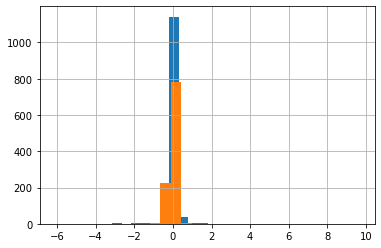

In [90]:
%matplotlib inline
beh_df.query('trial==69')['curvature'].hist(bins=20)
beh_df.query('trial==68')['curvature'].hist(bins=20)

<AxesSubplot:xlabel='Time (s)'>

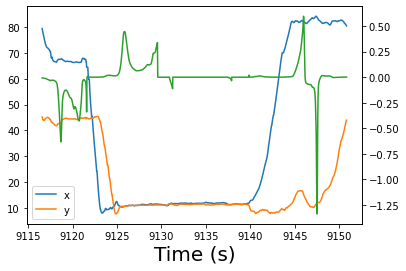

In [94]:
ax=beh_df.query('trial==40')[['x','y']].plot()
ax2=ax.twinx()
beh_df.query('trial==40')['curvature'].plot(ax=ax2,c='C2')